In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install imutils

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.layers import MaxPooling2D, Dropout, Flatten, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import os
from imutils import paths


In [1]:
from google.colab import files
uploaded = files.upload()

Saving car-damage-detection.zip to car-damage-detection.zip


In [4]:
import zipfile
with zipfile.ZipFile("car-damage-detection.zip", 'r') as zip_ref:
    zip_ref.extractall("car_data")
print("✅ Dataset extracted!")

✅ Dataset extracted!


In [5]:
data_dir = "car_data/dataset"
categories = ["damaged", "not_damaged"]
data = []
labels = []

In [6]:
data_dir = "car_data/data1a"


In [7]:
train_dir = "car_data/data1a/training"
val_dir = "car_data/data1a/validation"
categories = ["00-damage", "01-whole"]

print("[INFO] Loading and preprocessing images...")
data = []
labels = []

for dataset_dir in [train_dir, val_dir]:
    for category in categories:
        path = os.path.join(dataset_dir, category)
        for img_name in os.listdir(path):
            try:
                image = load_img(os.path.join(path, img_name), target_size=(224, 224))
                image = img_to_array(image)
                image = preprocess_input(image)
                data.append(image)
                labels.append(category)
            except Exception as e:
                print(f"Error loading image {img_name}: {e}")

[INFO] Loading and preprocessing images...


In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)

data = np.array(data, dtype="float32")
labels = np.array(labels)

(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.2, stratify=labels, random_state=42)


In [9]:
aug = ImageDataGenerator(
    rotation_range=20, zoom_range=0.15, width_shift_range=0.2,
    height_shift_range=0.2, shear_range=0.15, horizontal_flip=True,
    fill_mode="nearest"
)

In [10]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2


base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))
head_model = base_model.output
head_model = MaxPooling2D(pool_size=(5, 5))(head_model)
head_model = Flatten()(head_model)
head_model = Dense(128, activation="relu")(head_model)
head_model = Dropout(0.5)(head_model)
head_model = Dense(2, activation="softmax")(head_model)

model = Model(inputs=base_model.input, outputs=head_model)

<ipython-input-10-4999d09c10a2>:4: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
for layer in base_model.layers:
    layer.trainable = False

In [12]:
model.compile(loss="binary_crossentropy", optimizer=Adam(learning_rate=1e-4), metrics=["accuracy"])


In [13]:
print("[INFO] Training model...")
history = model.fit(
    aug.flow(trainX, trainY, batch_size=32),
    steps_per_epoch=len(trainX) // 32,
    validation_data=(testX, testY),
    validation_steps=len(testX) // 32,
    epochs=3
)

[INFO] Training model...


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/3


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(None, 224, 224, 3))
  warnings.warn(msg)


57/57 ━━━━━━━━━━━━━━━━━━━━ 127s 2s/step - accuracy: 0.5494 - loss: 1.5731 - val_accuracy: 0.7674 - val_loss: 0.5638
Epoch 2/3
 1/57 ━━━━━━━━━━━━━━━━━━━━ 1:43 2s/step - accuracy: 0.7188 - loss: 0.7358

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


57/57 ━━━━━━━━━━━━━━━━━━━━ 22s 366ms/step - accuracy: 0.7188 - loss: 0.7358 - val_accuracy: 0.7696 - val_loss: 0.5640
Epoch 3/3
57/57 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.7302 - loss: 0.6164 - val_accuracy: 0.8022 - val_loss: 0.4879


In [14]:
print("[INFO] Evaluating model...")
predictions = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=lb.classes_))


[INFO] Evaluating model...


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(32, 224, 224, 3))
  warnings.warn(msg)


15/15 ━━━━━━━━━━━━━━━━━━━━ 21s 1s/step
              precision    recall  f1-score   support

   00-damage       0.91      0.67      0.77       230
    01-whole       0.74      0.93      0.83       230

    accuracy                           0.80       460
   macro avg       0.83      0.80      0.80       460
weighted avg       0.83      0.80      0.80       460



In [15]:
model.save("car_damage_model.h5")


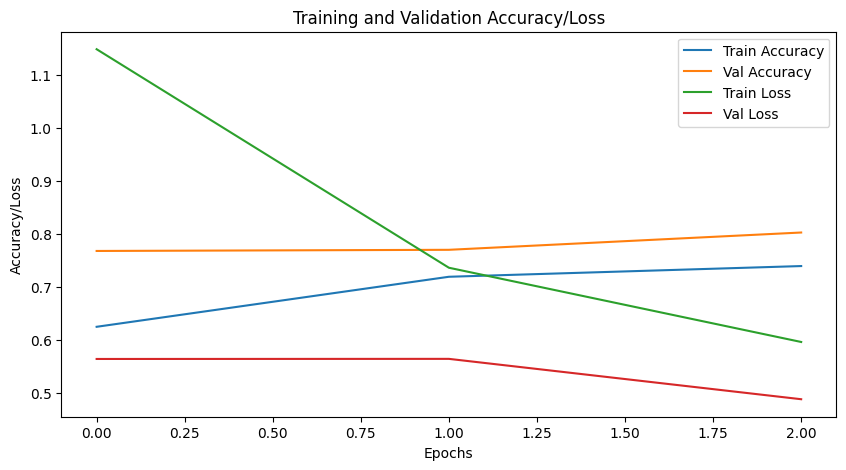

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.title("Training and Validation Accuracy/Loss")
plt.xlabel("Epochs")
plt.ylabel("Accuracy/Loss")
plt.legend()
plt.show()

In [17]:
model.save("car_damage_detector.h5")
from google.colab import files
files.download("car_damage_detector.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>